## A Hands-On guide to build your first Convolutional Neural Network model

Multi-layer perceptron (MLP) is a very general type of Artificial Neural Network (ANN) where all the neurons at one layer are fully connected to the neurons at the next layer. This "over-connectedness," together with non-linear activation, gives MLP the potential to approximate any continuous function. However, in actual applications such as healthcare where data is often limited, the network's high flexibility leads to an over-fitting and fails to represent the true association in the data.


In classical machine learning, adding regularizers to the parameter estimates was the most common approach to address the over-fitting problem. In Deep learning, we do it quite differently. Instead of adding a regularizer, we limit the learning capacity of MLP by removing some of the connections that are deemed unnecessary for the given task. The process of pruning unnecessary connections in MLP for Vision problems naturally produces Convolutional Neural Network (CNN).

<figure>
  <img src="https://www.researchgate.net/profile/Md-Jan-Nordin/publication/333075204/figure/fig2/AS:880657102274561@1586976423611/Architecture-of-LeNet-5-The-input-of-the-architecture-is-32x32-pixel-image-With-the.png" width="60%" height="30%" alt=""/>
  <figcaption>LeNet: One of the first CNN models proposed by Yann LeCun in 1998.</figcaption>
</figure>


As you can infer from the name of the network, each layer in CNN comprises of an operation called ***Convolution***($\circledast$). Given a 2D spatial input $\mathbf{X}$ with size height $H$, width $W$ and channel size $C$, Convolution of $X$ with weight $W$ of kernel size $[2K+1, 2K+1,C]$ is defined as

$$
(\mathbf{W} \circledast \mathbf{X})[h, w] =\sum_{c'=1}^{C} \sum_{h'=-k}^{k}\sum_{w'=-k}^{k}\mathbf{w}[h',w',c'] \ast \mathbf{x}[h+h',w+w',c'].
$$

Graphically, convolutions operations can be interpreted as a sliding local summation operation, shown in the figure below.

<figure>
  <img src="./Figs/convolution.png" width="60%" height="30%" alt=""/>
  <figcaption>2D convolution between input X and weight W</figcaption>
</figure>
That is it! Really this is all about CNN; replacing matrix operation in MLP ($X \times W $) to convolution ($X \circledast W$) gives us CNN.

Now, let's start building our own CNN for two example tasks: **1) brand logo detection** and **2) EEG-based emotion detection**.
For the brand logo detection task, since the input is 2D, we will use 2D-CNN. For EEG-based emotion detection, since the input is 1D, we will use 1D-CNN.

<br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br />

### Task 1) Brand Logo detection

In brand logo detection task, we have two objectives: given an image, 1) classify the correct logo, and 2) detect the location and size of the logo. If the model is well trained, the model can output a prediction like the figure below.

<figure>
  <img src="https://cdn-images-1.medium.com/max/800/1*YrTLY4sHzVOf_83XfjUhwg.jpeg" width="20%" height="30%" alt=""/>
  <figcaption>A detection model can predict logo as well as it's size and location</figcaption>
</figure>

Lets first start calling required packages.

In [1]:
#!pip install --upgrade albumentations
#!pip install toolz
#!pip install pybboxes

import os, re, sys, time

import numpy as np
import pandas as pd

from toolz import *
from toolz.curried import *
from toolz.curried.operator import *

import torch
import torch.nn as nn
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.models import alexnet

import albumentations as A
import pybboxes as pbx
 
import cv2
from PIL import Image
from matplotlib import pyplot as plt

### Dataset: [Flickr Logos 27 dataset](http://image.ntua.gr/iva/datasets/flickr_logos/)

We download the dataset from the web using the commands below. The commands download a zip folder, unzip the folder, unzip another zip folder that contains images, and lastly, delete all the zip folders.

In [2]:
# runs only if "flickr_logos_27_dataset.tar.gz" does not exist in directory
if "flickr_logos_27_dataset" not in os.listdir("."):
  # download tar.gz
  !wget http://image.ntua.gr/iva/datasets/flickr_logos/flickr_logos_27_dataset.tar.gz -P .

  # unzip tar.gz
  !tar -xf flickr_logos_27_dataset.tar.gz 
  !tar -xf flickr_logos_27_dataset/flickr_logos_27_dataset_images.tar.gz --directory flickr_logos_27_dataset/

  # removes tar.gz after unzip
  !rm flickr_logos_27_dataset/flickr_logos_27_dataset_images.tar.gz
  !rm flickr_logos_27_dataset.tar.gz

print("\nIn flickr_logos_27_dataset folder ...\n")
!ls flickr_logos_27_dataset/flickr_logos_27_dataset_images/ | head -10

print("\nIn flickr_logos_27_dataset_training_set_annotation ...\n")
!head -10 flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt


In flickr_logos_27_dataset folder ...

106523337.jpg
1075391489.jpg
108232382.jpg
108232417.jpg
109950015.jpg
110022360.jpg
1107796028.jpg
1111800334.jpg
111389662.jpg
115519078.jpg
ls: write error: Broken pipe

In flickr_logos_27_dataset_training_set_annotation ...

144503924.jpg Adidas 1 38 12 234 142 
2451569770.jpg Adidas 1 242 208 413 331 
390321909.jpg Adidas 1 13 5 89 60 
4761260517.jpg Adidas 1 43 122 358 354 
4763210295.jpg Adidas 1 83 63 130 93 
4763210295.jpg Adidas 1 91 288 125 306 
4763210295.jpg Adidas 1 182 63 229 94 
4763210295.jpg Adidas 1 192 291 225 306 
4763210295.jpg Adidas 1 285 61 317 79 
4763210295.jpg Adidas 1 285 298 324 329 


### Dataloader

Now let's build a data-loading pipeline that include simple augmentation methods.

In [3]:
def parseImage(file):
    # file : xxx.jpg
    # img  : cv2 type image tensor
    return plt.imread(file)

def parseLabels(file):
    # files  : xxx_annotaiton.txt
    # labels : {image_name, label_id, label} 

    df = pd.read_csv(file, sep = " ", header = None)
    df = df[df[0].str.contains("2662264721")==False] # this image is faulty. Hence removing.

    image_names = list(df[0])
    labels      = list(df[1])
    bboxes      = df.iloc[:,3:7].values.tolist()
    label_id_D  = dict(zip(set(labels), range(len(set(labels)))))

    return ([{"image_name" : image_name,
            "label_id"   : label_id_D[label],
            "label"      : label,
            "bbox"       : compose(list, map(int))(bbox)
             }

          for image_name, label, bbox in zip(image_names, labels, bboxes)],

          label_id_D)

def augment(train):
    # tarin : bool
    if train:
        return A.Compose([A.HorizontalFlip(p=0.25),                                         
                         A.RandomBrightnessContrast(p=0.25),
                         A.Resize(256, 256),
                         A.Normalize()],
                         bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))

    else:
        return A.Compose([A.NoOp(),
                         A.Normalize()],
                         bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))

class FlickrDataset(Dataset):
    def __init__(self, datasetDir, imgFile, labelFile,
                 transform = augment,
                 train     = True,
                 currupted = ["2662264721"]):

        self.datasetDir              = datasetDir
        self.imgFile                 = imgFile
        self.labelFile               = labelFile
        self.labels, self.label_id_D = parseLabels(f"{datasetDir}/{labelFile}")        
        self.transform               = transform(train)       

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        img_id, label_id, label, bbox = self.labels[idx].values()

        imgPath = f"{self.datasetDir}/{self.imgFile}/{img_id}"
        img     = parseImage(imgPath)

        sample = self.transform(image=img,
                                bboxes=[pbx.convert_bbox(bbox,
                                                         from_type="voc",
                                                         to_type="yolo",
                                                         image_size=img.shape[:-1][::-1])],
                                category_ids=[label_id])

        return (torch.tensor(sample["image"]),
                torch.tensor(sample["category_ids"][0]),
                torch.tensor(sample["bboxes"][0]))
    
    
dataset = FlickrDataset("flickr_logos_27_dataset",
                        "flickr_logos_27_dataset_images",
                        "flickr_logos_27_dataset_training_set_annotation.txt",
                        train = True)

dataLoader = DataLoader(dataset,
                        batch_size = 32,
                        shuffle = True,
                        num_workers=2)    

### Model

  * We will be using [AlexNet](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) with two prediction heads

  * logo prediction head and bounding box (location and size of a rantangle) prediction.

<figure>
  <img src="https://miro.medium.com/max/1400/1*5bnqbGcBSLzaNMsz5dHkfg.png" width="60%" height="30%" alt=""/>
  <figcaption>Architecure of AlexNet</figcaption>
</figure>

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.backbone = nn.Sequential(alexnet(pretrained = True).features,
                                      nn.AdaptiveAvgPool2d(output_size = (1,1)),
                                      nn.Flatten())
        
        # logo prediction head
        self.logo_layer = nn.Sequential(
                    nn.Linear(256,256), # output of Alexent has 256 channels.
                    nn.ReLU(),
                    nn.Linear(256,128), 
                    nn.ReLU(),
                    nn.Linear(128, 27)) # total of 27 logos.
        
        # bbox prediction head. 
        self.bbox_layer = nn.Sequential(
                    nn.Linear(256,256), 
                    nn.ReLU(),
                    nn.Linear(256,128), 
                    nn.ReLU(),
                    nn.Linear(128, 4), # predict four real numbers (x_c, y_c, h, w) 
                    nn.Softplus())     # make it positive tive softplus operatio 
  
    def forward(self, x):
        z = self.backbone(x)

        return self.logo_layer(z), self.bbox_layer(z)
    
cnn = CNN().cuda().train() # change all the weights in the network to cuda tensor for GPU accelerated computation    

### Optimizer

Here, we use an ADAM optimizer for faster convergence and less sensitivity to the learning rate choice.

<figure>
  <img src="https://blog.paperspace.com/content/images/2018/06/optimizers7.gif" width="60%" height="30%" alt=""/>
  <figcaption>Fast convergence of Adam optimizer compared to other optimization techniques
   </figcaption>
</figure>

In [5]:
optimizer = torch.optim.Adam(cnn.parameters(),
                             lr = 0.001)

### Loss

As mentioned previously, we have two predictions heads. We need different loss for each head. We will use Cross entropy (CE) for logo prediction head, and Mea squared error (MSE) for bounding box prediction head.

  * Cross Entropy loss (CE)

$$ L({y},\hat{y})_{CE} = - \sum_{i=1}^{N} y_i \cdot \text{log} \hat{y}_i$$

  * Mean Squared Error loss (MSE)

$$ L({y},\hat{y})_{MSE} = - \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$$  


In [6]:
CE  = torch.nn.CrossEntropyLoss()
MSE = torch.nn.MSELoss()

### Training

We will training for 20 epochs.

In [7]:
for e in range(20):
    TOTAL_losses = []
    CE_losses    = []
    MSE_losses   = []
    for images,labels,bboxs in dataLoader:
        
        images = images.type(torch.float32).permute(0,3,1,2).cuda()
        labels = labels.type(torch.long).squeeze().cuda()
        bboxs  = bboxs.type(torch.float32).squeeze().cuda()

        optimizer.zero_grad()

        label_preds, bbox_preds = cnn(images)

        CE_loss  = CE(label_preds, labels.reshape(-1))
        MSE_loss1 = MSE(bbox_preds[:,:2], bboxs[:,:2])
        MSE_loss2 = MSE(bbox_preds[:,2:]**0.5, bboxs[:, 2:]**0.5)
        
        MSE_loss = MSE_loss1 + MSE_loss2

        TOTAL_loss = CE_loss + 10*MSE_loss

        TOTAL_losses.append(TOTAL_loss.item())
        CE_losses.append(CE_loss.item())
        MSE_losses.append(MSE_loss.item())

        TOTAL_loss.backward()                        
        optimizer.step()
        
    print(f"Loss at epoch:{e} = {np.mean(TOTAL_losses)} (CE_loss:{np.mean(CE_losses)}, MSE_loss:{np.mean(MSE_losses)})")    

Loss at epoch:0 = 2.7122572400200533 (CE_loss:1.9678840528071766, MSE_loss:0.0744373178975263)
Loss at epoch:1 = 1.3302877889552587 (CE_loss:0.7688211246695317, MSE_loss:0.056146666643695095)
Loss at epoch:2 = 0.9460098055047048 (CE_loss:0.4467870406806469, MSE_loss:0.049922276406325926)
Loss at epoch:3 = 0.7472094257532711 (CE_loss:0.2707480609180852, MSE_loss:0.04764613650844131)
Loss at epoch:4 = 0.6589928258892516 (CE_loss:0.21577512295785503, MSE_loss:0.0443217701763964)
Loss at epoch:5 = 0.6173308388867849 (CE_loss:0.1786028774025601, MSE_loss:0.04387279613022233)
Loss at epoch:6 = 0.6092474278010113 (CE_loss:0.17391282584334553, MSE_loss:0.04353346006656197)
Loss at epoch:7 = 0.574878774478402 (CE_loss:0.15035026444082844, MSE_loss:0.04245285085126967)
Loss at epoch:8 = 0.44700649905372675 (CE_loss:0.06061439705306736, MSE_loss:0.03863921029571916)
Loss at epoch:9 = 0.4618058747179072 (CE_loss:0.07910833083557188, MSE_loss:0.03826975434179038)
Loss at epoch:10 = 0.52187812223400

### Evaluation

We evaluate the trained model in 2 ways: 1) logo prediction accuracy, and 2) visually observe the predicted bounding box to see if it covers the correct region in the image.

In [14]:
cnn.eval()

yHats = []
ys    = []
for images,labels,bboxs in dataLoader:

    images = images.type(torch.float32).permute(0,3,1,2).cuda()
    labels = labels.type(torch.long).squeeze().cuda()
    bboxs  = bboxs.type(torch.float32).squeeze().cuda()

    label_preds, bbox_preds = cnn(images)

    ys.append(labels.detach().cpu().numpy())
    yHats.append(nn.functional.softmax(label_preds, dim = 1).detach().cpu().numpy())
    
yHats = np.argmax(np.concatenate(yHats), axis = 1)
ys    = np.concatenate(ys).astype(int)

print("Test Accuracy:")
for label, label_id in dataset.label_id_D.items() :
    
    acc = np.sum(yHats[np.where(ys == label_id)] == label_id) / sum(ys == label_id)*100
    acc = str(acc)[:5]
    print(f"    {label} : {acc}%")

Test Accuracy:
    Nbc : 100.0%
    Intel : 100.0%
    Porsche : 100.0%
    Texaco : 100.0%
    HP : 100.0%
    Adidas : 100.0%
    Heineken : 100.0%
    Starbucks : 100.0%
    RedBull : 100.0%
    McDonalds : 100.0%
    Unicef : 100.0%
    Yahoo : 100.0%
    Cocacola : 98.57%
    Citroen : 100.0%
    Google : 100.0%
    BMW : 100.0%
    Puma : 100.0%
    Mini : 100.0%
    Pepsi : 100.0%
    DHL : 100.0%
    Fedex : 100.0%
    Ferrari : 100.0%
    Apple : 100.0%
    Vodafone : 100.0%
    Ford : 100.0%
    Nike : 100.0%
    Sprite : 100.0%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


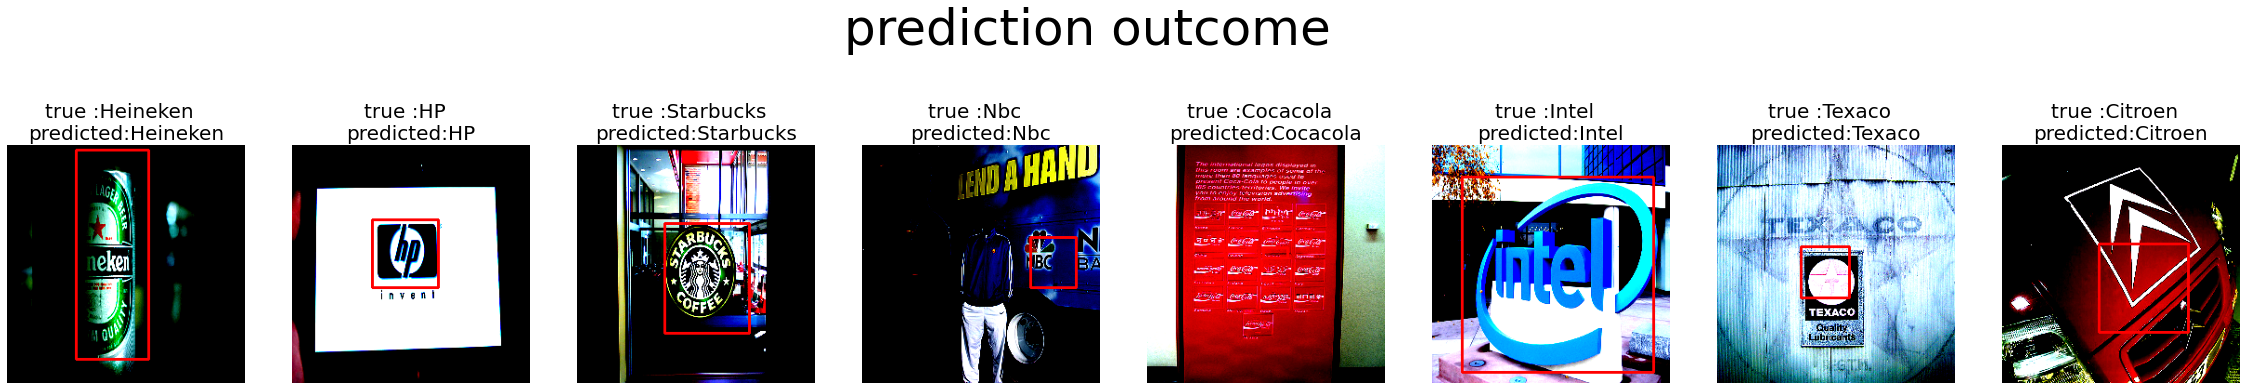

In [15]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize(image, bbox):

    """
    the code is imported from https://albumentations.ai/docs/examples/example_bboxes/
    """

    def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
        """Visualizes a single bounding box on the image"""
        x_min, y_min, x_max, y_max = bbox

        x_min = int(x_min)
        y_min = int(y_min)
        x_max = int(x_max)
        y_max = int(y_max)

        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

        return img

    img = image.copy()

    img = visualize_bbox(img,
                        pbx.convert_bbox(bbox,
                                        from_type="yolo",
                                        to_type="voc",
                                        image_size=img.shape[:-1][::-1]))
      
    return img

def plotBatch(imgs, labels, label_preds, bboxs, bbox_preds):
    
    fig, axes = plt.subplots(1,len(imgs), figsize = (len(imgs) * 5, 1.5 * 5))
    fig.suptitle("prediction outcome" , fontsize=50)

    for ax, img, label, label_pred, bbox, bbox_pred in zip(axes, imgs, labels, label_preds, bboxs, bbox_preds): 

        img = visualize(np.transpose(img, (1,2,0)), bbox_pred)
        
        ax.imshow(img)
        ax.set_title(f"true :{list(dataset.label_id_D.keys())[label]}  \npredicted:{list(dataset.label_id_D.keys())[label_pred]}", fontsize=20)
        ax.axis('off')
    
    plt.show()
    
X           = images.detach().cpu().numpy()[:8]
label_preds = np.argmax(label_preds.detach().cpu().numpy(), axis = 1)[:8].astype(int)
labels      = labels.detach().cpu().numpy()[:8].astype(int)
bbox_preds  = bbox_preds.detach().cpu().numpy()[:8]
bboxs       = bboxs.detach().cpu().numpy()[:8]

plotBatch(X, labels, label_preds, bboxs, bbox_preds)    

<br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br />

### Task 2) Detecting emotion from EEG data

We now work with EEG data. As shwon in the figure below, EEG data refers to the recording of the electrical signals that are detected by electrodes placed on the scalp. During an EEG test, electrodes are attached to specific points on the scalp, and these electrodes detect the electrical activity that is produced by the brain. The signals are then amplified and recorded by a machine, which produces a visual representation of the electrical activity in the form of a graph. EEG data can be used to diagnose a variety of conditions, such as epilepsy, sleep disorders, and brain injuries. It is also used in research to study brain activity and cognitive processes.

In this task, we use EEG for detecting emotion. We will use the open-source dataset from [Kaggle challenge](https://www.kaggle.com/code/shreyaspj/detecting-emotions-using-eeg-waves/notebook).


<figure>
  <img src="https://sccn.ucsd.edu/~arno/fam2data/eeg.png" width="50%" height="30%" alt=""/>
  <figcaption></figcaption>
</figure>

In [58]:
import matplotlib.pyplot as plt

from toolz import *
from toolz.curried import *
from toolz.curried.operator import *

import pandas as pd
import numpy as np
import torch

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.metrics import accuracy_score
import seaborn as sns

### Dataset: [EEG Brainave Dataset: Feeling emotions](https://www.kaggle.com/code/shreyaspj/detecting-emotions-using-eeg-waves/input?select=emotions.csv)

The dataset is available in "./sample_data" folder. We will first load the dataset and visualize the sturcture of the dataset and also plot some EEG signals to spot if there is any noticable difference across emotions.

In [26]:
data = pd.read_csv("./sample_data/emotions.csv")
data.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


### Data prerpocessing

We will do the following preprocessings
* sample only columns from fft_0_b to fft_749_b + label.
* change label to integer
* make a train test split

In [47]:
# select fft columns only
X = data.loc[:,'fft_0_b':'fft_749_b']

# replace characters to integers in label column
y = data["label"].replace({"POSITIVE": 2, "NEUTRAL" : 1, "NEGATIVE" : 0})


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

### Visualize

Here we visualize if we can find any noticable trend across emotions. We test two simple visualization tehchniques: 1) mean across sample, and 2) standard deviatino across sample.

The two plots below clearly show distinctive trends across emotions, providing evidences that we can possibly fit a model to the data.

<AxesSubplot:title={'center':'STD'}>

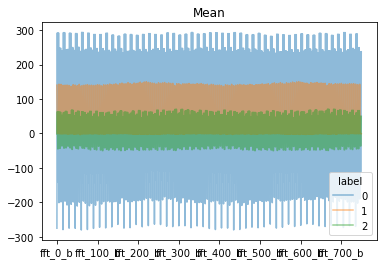

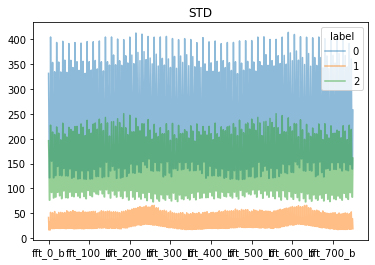

In [57]:
pd.concat([X, y], axis=1).groupby(['label']).mean().T.plot(legend=True, alpha = 0.5, title='Mean')
pd.concat([X, y], axis=1).groupby(['label']).std().T.plot(legend=True, alpha = 0.5, title='STD')

### Data Pipeline

Since the dataset can easily fit into GPU memory, we do not have to do complicated parsing like the logo detection task. Hence, we will use the **TensorDataset** function in Pytorch.utils to automatically convert torch.tensor to Dataset class and subsequently change to DataLoader.

In [112]:
dataset_train = TensorDataset(torch.tensor(np.array(X_train)),
                              torch.tensor(np.array(y_train)))
dataset_test  = TensorDataset(torch.tensor(np.array(X_test)),
                              torch.tensor(np.array(y_test)))

loader_train = DataLoader(dataset_train, batch_size=8, pin_memory=True, shuffle = True)
loader_test  = DataLoader(dataset_test, batch_size=1, pin_memory=True, shuffle = True)

In [91]:
class CNN_1D(nn.Module):
    def __init__(self):
        super(CNN_1D, self).__init__()

        self.backbone = nn.Sequential(nn.Conv1d(1,  16, kernel_size = 5, dilation = 1),
                                      nn.ReLU(),
                                      nn.Conv1d(16, 32, kernel_size = 5, dilation = 3),
                                      nn.ReLU(),
                                      nn.Conv1d(32, 64, kernel_size = 5, dilation = 5),
                                      nn.ReLU(),
                                      nn.Conv1d(64, 64, kernel_size = 5, dilation = 7),
                                      nn.ReLU(),
                                      nn.Conv1d(64, 64, kernel_size = 5, dilation = 9),
                                      nn.ReLU(),
                                      nn.AdaptiveAvgPool1d(1))
        
        # logo prediction head
        self.emotion_layer = nn.Sequential(
                    nn.Linear(64, 64), # output of Alexent has 256 channels.
                    nn.ReLU(),
                    nn.Linear(64, 3)) # total of 3 emotions (positive, neutral, negative).
          
    def forward(self, x):
        z = self.backbone(x).flatten(start_dim = 1)
        return self.emotion_layer(z)
    
cnn = CNN_1D().cuda().train() # change all the weights in the network to cuda tensor for GPU accelerated computation    

### Optimizer

Same as the previous logo detection task, we use Adam Optimizer

In [92]:
optimizer = torch.optim.Adam(cnn.parameters(),
                             lr = 0.0003)

### Loss

Emotion is a categorical variable. Hence, we use CE loss

  * Cross Entropy loss (CE)

$$ L({y},\hat{y})_{CE} = - \sum_{i=1}^{N} y_i \cdot \text{log} \hat{y}_i$$

In [93]:
loss = nn.CrossEntropyLoss()

### Training

We train model for 50 epochs

In [101]:
for e in range(50):
    losses = []
    for x, y in loader_train:
        
        x = x.type(torch.float32).unsqueeze(1).cuda()
        y = y.type(torch.long).squeeze().cuda()

        optimizer.zero_grad()

        pred = cnn(x)

        loss = CE(pred, y)
        
        loss.backward()                        
        optimizer.step()
                
        losses.append(loss.item())
        
    if e%10 == 0 : print(f"Loss at epoch:{e} = {np.mean(losses)}")    

Loss at epoch:0 = 5.723581626711698e-07
Loss at epoch:10 = 1.0566179090796886e-07
Loss at epoch:20 = 2.1036862348368118e-08
Loss at epoch:30 = 6.374821008562698e-09
Loss at epoch:40 = 1.992133217745784e-09


### Evaluation

We evaluate the trained model on the reserved test-set using confusion matrix, and accuracy.

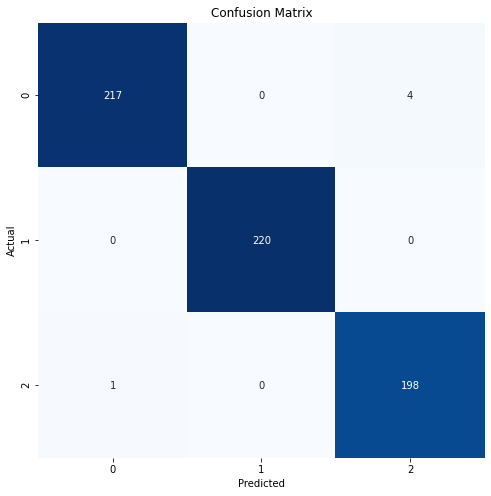

Acc : 99.21875%


In [115]:
cnn.eval()

yHats = []
ys    = []
for x, y in loader_test:

        x = x.type(torch.float32).unsqueeze(1).cuda()
        y = y.type(torch.long).squeeze().cuda()

        pred = cnn(x)
        
        yHats.append(pred.detach().cpu().numpy())
        ys.append(y.detach().cpu().numpy())
    
yHats = np.argmax(np.concatenate(yHats), axis = 1)
ys    = np.stack(ys).astype(int)


cm = confusion_matrix(ys, yHats)
acc = sum(ys == yHats)/len(ys)*100

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(f"Acc : {acc}%")